In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
PATH='chest_xray/'

In [5]:
train_dir = os.path.join(PATH,'train')
validation_dir = os.path.join(PATH,'test')

In [6]:
ls $PATH

test/  train/  val/


In [7]:
ls chest_xray/train

NORMAL/  PNEUMONIA/


In [8]:
train_normal_dir = os.path.join(train_dir, 'NORMAL')  
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')  
validation_normal_dir = os.path.join(validation_dir, 'NORMAL')
validation_pneumonia_dir = os.path.join(validation_dir, 'PNEUMONIA')

In [9]:
num_normal_tr = len(os.listdir(train_normal_dir))
num_pneumonia_tr = len(os.listdir(train_pneumonia_dir))

num_normal_val = len(os.listdir(validation_normal_dir))
num_pneumonia_val = len(os.listdir(validation_pneumonia_dir))

total_train = num_normal_tr + num_pneumonia_tr
total_val = num_normal_val + num_pneumonia_val

print('total training normal images:', num_normal_tr)
print('total training pneumonia images:', num_pneumonia_tr)

print('total validation normal images:', num_normal_val)
print('total validation pneumonia images:', num_pneumonia_val)
print("--")
print("Total training imag:", total_train)
print("Total validation images:", total_val)

total training normal images: 1341
total training pneumonia images: 3875
total validation normal images: 234
total validation pneumonia images: 390
--
Total training imag: 5216
Total validation images: 624


In [10]:
batch_size = 8
epochs = 4
IMG_HEIGHT = 240
IMG_WIDTH = 240

In [11]:
img_generator_train = ImageDataGenerator(rescale=1./255,
                                         horizontal_flip=True,
                                         rotation_range=45,
                                         zoom_range=0.5,
                                         width_shift_range=0.15,
                                         height_shift_range=0.15)

img_data_gen = img_generator_train.flow_from_directory(directory=train_dir,
                                                       target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                       batch_size=batch_size,
                                                       class_mode='binary')

Found 5216 images belonging to 2 classes.


In [12]:
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size, directory=validation_dir,
                                                             shuffle=True, target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                             class_mode='binary')

Found 624 images belonging to 2 classes.


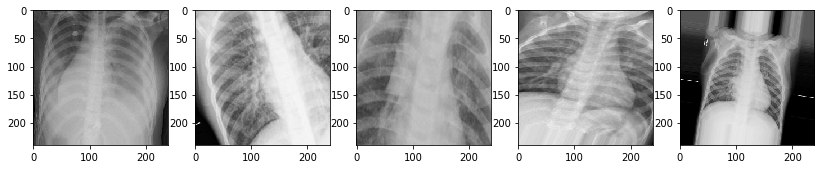

In [14]:
samples,_ = next(img_data_gen) 
plt.figure(figsize=(14,5))
for n,im in enumerate(samples[:5]):
    plt.subplot(1,5,n+1)
    plt.imshow(im)

In [15]:
import keras
import efficientnet.keras as efn 

from keras.models import Model, load_model
from keras.layers import Dense, Flatten
from keras import backend as K

import imgaug as ia
import imgaug.augmenters as iaa

import glob
import cv2

import numpy
import pandas as pd

numpy.random.bit_generator = numpy.random._bit_generator

Using TensorFlow backend.


In [20]:
def get_model():
        K.clear_session()
        base_model =  efn.EfficientNetB2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
        x = base_model.output
        x = keras.layers.GlobalAveragePooling2D()(x)
        y_pred = Dense(1, activation='sigmoid')(x)
        return Model(inputs=base_model.input, outputs=y_pred)

In [21]:
model = get_model()










Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [22]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 120, 120, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 120, 120, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 120, 120, 32) 0           stem_bn[0][0]                    
__________________________________________________________________________________________________
block1a_dw

In [23]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [25]:
history = model.fit_generator(img_data_gen, steps_per_epoch=total_train//batch_size,
                              epochs=epochs,
                              validation_data=val_data_gen,
                              validation_steps=total_val//batch_size)



Epoch 1/4
652/652 [==============================] - 260s 399ms/step - loss: 0.2657 - acc: 0.8854 - val_loss: 0.3249 - val_acc: 0.8830
Epoch 2/4
652/652 [==============================] - 229s 351ms/step - loss: 0.1869 - acc: 0.9279 - val_loss: 0.2888 - val_acc: 0.8798
Epoch 3/4
652/652 [==============================] - 231s 354ms/step - loss: 0.1546 - acc: 0.9419 - val_loss: 0.3368 - val_acc: 0.8862
Epoch 4/4
652/652 [==============================] - 233s 357ms/step - loss: 0.1430 - acc: 0.9454 - val_loss: 0.5481 - val_acc: 0.8478


In [ ]:
model.save('efficientNet_240_240_demo')